## This is the main notebook for intersubject alignment study


In [1]:
import numpy as np
import os
import glob
from os.path import join as opj
import h5py  
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from scipy.io import loadmat
import torch
from torch.utils.data import Dataset, Subset, DataLoader
import json
import clip
from PIL import Image
# from diffusers import VersatileDiffusionPipeline
# from diffusers import VersatileDiffusionDualGuidedPipeline
from diffusers.models import AutoencoderKL, DualTransformer2DModel, Transformer2DModel, UNet2DConditionModel
from versatile_diffusion_dual_guided import VersatileDiffusionDualGuidedPipeline
from versatile_diffusion_dual_guided_fake_images import VersatileDiffusionDualGuidedFromCLIPEmbeddingPipeline
from autoencoder import *
from torchsummary import summary
import torchvision
import tqdm
from sklearn.linear_model import Ridge
import pickle
import wandb
from diffusers.utils import (
    PIL_INTERPOLATION,
    deprecate,
    is_accelerate_available,
    is_accelerate_version,
    logging,
    randn_tensor,
    replace_example_docstring,
)

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from decoding import *
from wandb import AlertLevel


# from yellowbrick.cluster import KElbowVisualizer

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
source_sub_idx=2  ## idx of subject aligned
target_sub_idx=1  ## idx of the subject used as template for alignment


method="ridge"
fraction=100


In [3]:
base_path="/home/matteo/data/NSD"
timeseries_path=opj(base_path,"nsddata_timeseries")
betas_path=opj(base_path,"nsddata_betas")

stimuli_path=opj(base_path,"nsddata_stimuli","stimuli","nsd")
stim_file_path=opj(stimuli_path,"nsd_stimuli.hdf5")
sub=f"subj0{target_sub_idx}"
mod="func1pt8mm"
sub_idx=target_sub_idx
subj_data_path=opj(timeseries_path,"ppdata",sub,mod,"timeseries")
subj_betas_path=opj(betas_path,"ppdata",sub,mod,"betas_assumehrf")

subj_betas_roi_extracted_path=opj(base_path,"processed_roi",sub,mod)

stim_order_path=opj(base_path,"nsddata","experiments","nsd","nsd_expdesign.mat")
stim_info_path=opj(base_path,"nsddata","experiments","nsd","nsd_stim_info_merged.csv")
stim_captions_train_path=opj(base_path,"nsddata_stimuli","stimuli","nsd","annotations",f"captions_train2017.json")
stim_captions_val_path=opj(base_path,"nsddata_stimuli","stimuli","nsd","annotations",f"captions_val2017.json")

processed_data=opj(base_path,"processed_roi",sub)

In [4]:
fmri_train_data=opj(processed_data,f"MNI/nsd_train_fmriavg_nsdgeneral_sub{target_sub_idx}.npy")
imgs_train_data=opj(processed_data,f"MNI/nsd_train_stim_sub{target_sub_idx}.npy")
captions_train_data=opj(processed_data, f"MNI/nsd_train_cap_sub{target_sub_idx}.npy")
       
fmri_test_data=opj(processed_data,f"MNI/nsd_test_fmriavg_nsdgeneral_sub{target_sub_idx}.npy")
imgs_test_data=opj(processed_data,f"MNI/nsd_test_stim_sub{target_sub_idx}.npy")
captions_test_data=opj(processed_data, f"MNI/nsd_test_cap_sub{target_sub_idx}.npy")



## extra data
imgs_comparison_data=f"/home/matteo/data/NSD/processed_roi/subj0{source_sub_idx}/aligned/nsd_comparison_stim_sub{source_sub_idx}.npy"
fmri_aligned_data=opj(f"/home/matteo/data/NSD/processed_roi/subj0{source_sub_idx}",f"aligned/nsd_comparison_fmriavg_nsdgeneral_sub{source_sub_idx}.npy") 
fmri_notaligned_data=opj(f"/home/matteo/data/NSD/processed_roi/subj0{source_sub_idx}",f"aligned/nsd_comparison_NOTALIGNED_fmriavg_nsdgeneral_sub{source_sub_idx}.npy")  


In [5]:
train_fmri=torch.load(f"/home/matteo/explore_NSD_MNI//models/{sub}/train_fmri.pt")
mean=train_fmri.mean(0)
std=train_fmri.std(0)

In [6]:
def get_aligned_dataset(source_sub_idx,target_sub_idx,method="ridge",split="comparison",fraction=10):
    
    ## LAVORARE QUI
    
    assert method in ["ridge","hyper","randomhyper", "anat"], 'method should be in ["ridge","hyper","randomhyper", "anat"]'
    assert split in ["comparison","test","train"], 'split should be in ["comparison","test","train"]'
    assert fraction in [10,25,50,100], 'fraction should be 10,25, 50 or 100'
    
    
    # load stimuli
    if split=="comparison":
        imgs_data=f"/home/matteo/data/NSD/processed_roi/subj0{source_sub_idx}/aligned_to_subj0{target_sub_idx}/nsd_comparison_stim_sub{source_sub_idx}.npy"
    elif split=="test": 
        imgs_data=f"/home/matteo/data/NSD/processed_roi/subj0{source_sub_idx}/aligned_to_subj0{target_sub_idx}/nsd_test_stim_sub{source_sub_idx}.npy"
    elif split=="train":
        imgs_data=opj(base_path,"processed_roi",f"subj0{source_sub_idx}",f"MNI/nsd_train_stim_sub{source_sub_idx}.npy")

    # load aligned data
    
    if method=="anat":
        if split=="train":
            data=opj(base_path,"processed_roi",f"subj0{source_sub_idx}",f"MNI/nsd_train_fmriavg_nsdgeneral_sub{source_sub_idx}.npy")
        else:
            data=opj(f"/home/matteo/data/NSD/processed_roi/subj0{source_sub_idx}",f"aligned_to_subj0{target_sub_idx}/nsd_{split}_NOTALIGNED_fmriavg_nsdgeneral_sub{source_sub_idx}.npy") 
    else:
    
        data=opj(f"/home/matteo/data/NSD/processed_roi/subj0{source_sub_idx}",f"aligned_to_subj0{target_sub_idx}/nsd_{split}_fmriavg_nsdgeneral_sub{source_sub_idx}_{method}_fraction-{fraction}.npy")
        
    
    
    return data,imgs_data

In [7]:
def get_dataset(source_sub_idx,target_sub_idx,method="ridge",split="comparison",fraction=10):

            
    ## Remove useful indices 
    indices=[25,31,68,121,126,318,384,492,531,606,702,860]

    indices2=[70,116,165,261,278,363,451,774]
    indices3=[41,205,230,411,428,446,502,777]
    extra=[95,905]
    comparison_indices=indices+indices2+indices3+extra

    align_indices=[i for i in  range(982) if i not in comparison_indices]
    
    tr=torchvision.transforms.ToTensor()

    if source_sub_idx!=target_sub_idx:
        
                
        base_path="/home/matteo/data/NSD"
        processed_data=opj(base_path,"processed_roi",f"subj0{source_sub_idx}")
        
        data,imgs_data=get_aligned_dataset(source_sub_idx,target_sub_idx,method,split,fraction)
        
            # load captions

        if split=="train":
            captions_data=opj(processed_data, f"MNI/nsd_train_cap_sub{source_sub_idx}.npy")
            dataset=NSDDataset(data,imgs_data,captions_data,transforms=tr)


        elif split=="comparison":
            captions_data=opj(processed_data, f"MNI/nsd_test_cap_sub{source_sub_idx}.npy")
            
            dataset=NSDDataset(data,imgs_data,captions_data,transforms=tr)
        
        elif split=="test":
            captions_data=opj(processed_data, f"MNI/nsd_test_cap_sub{source_sub_idx}.npy")
            
            dataset=NSDDataset(data,imgs_data,captions_data,transforms=tr)

    
    else:    
        
        base_path="/home/matteo/data/NSD"
        processed_data=opj(base_path,"processed_roi",f"subj0{source_sub_idx}")
        
        print("source_idx and target_idx are the same")
        
        if split=="train":
            data=opj(processed_data,f"MNI/nsd_train_fmriavg_nsdgeneral_sub{target_sub_idx}.npy")
            imgs_data=opj(processed_data,f"MNI/nsd_train_stim_sub{target_sub_idx}.npy")
            captions_data=opj(processed_data, f"MNI/nsd_train_cap_sub{target_sub_idx}.npy")
           
            dataset=NSDDataset(data,imgs_data,captions_data,transforms=tr)


        elif split=="comparison":
            data=opj(processed_data,f"MNI/nsd_test_fmriavg_nsdgeneral_sub{target_sub_idx}.npy")
            imgs_data=opj(processed_data,f"MNI/nsd_test_stim_sub{target_sub_idx}.npy")
            captions_data=opj(processed_data, f"MNI/nsd_test_cap_sub{target_sub_idx}.npy")
            
            dataset=NSDDataset(data,imgs_data,captions_data,transforms=tr)
            dataset=torch.utils.data.Subset(dataset,comparison_indices)
            
        elif split=="test":
            data=opj(processed_data,f"MNI/nsd_test_fmriavg_nsdgeneral_sub{target_sub_idx}.npy")
            imgs_data=opj(processed_data,f"MNI/nsd_test_stim_sub{target_sub_idx}.npy")
            captions_data=opj(processed_data, f"MNI/nsd_test_cap_sub{target_sub_idx}.npy")
            
            dataset=NSDDataset(data,imgs_data,captions_data,transforms=tr)
            dataset=torch.utils.data.Subset(dataset,align_indices)
        
    return dataset
        

In [8]:
# data,imgs_data=get_aligned_dataset(source_sub_idx,target_sub_idx,method=method, split="comparison", fraction=fraction)

dataset=get_dataset(source_sub_idx,target_sub_idx,method=method,split="comparison", fraction=fraction)

BS=4
# tr=torchvision.transforms.ToTensor()


# other_dataset=NSDDataset(data,imgs_data,captions_test_data,transforms=tr)
dataloader=DataLoader(dataset,batch_size=BS)


print(len(dataset))


30


## Load decoder

In [9]:
subj_path=opj("/home/matteo/explore_NSD_MNI","models",sub)
brain_decoder=BrainDiffuserPretrainedDecoder(subj_path=subj_path,device="cuda:0")

Loading pretrained deep learning backbones


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pretrained brain to feature models
loading brain to latent models
loading brain to img embeddings models
loading brain to txt embeddings models
loading adjust values
loading predicted values for adjusting


### for each subject generate decoded images

In [10]:

generated=[]
for source_idx in [1,2,5,7]:

    dataset=get_dataset(source_idx,target_sub_idx,method=method,split="comparison", fraction=fraction)

    BS=4


    # other_dataset=NSDDataset(data,imgs_data,captions_test_data,transforms=tr)
    dataloader=DataLoader(dataset,batch_size=BS,shuffle=False)
    
    # x,y,c=next(iter(dataloader))
    gen_tmp=[]
    for x,y,c in dataloader:
    
        x_norm=torch.nan_to_num((x-mean)/std)
        image_generated,guess_img=brain_decoder.decode(x_norm)
        gen_tmp+=image_generated
    generated.append(gen_tmp)

source_idx and target_idx are the same


100%|███████████████████████████████████████████| 77/77 [01:06<00:00,  1.15it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [01:00<00:00,  1.27it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:58<00:00,  1.33it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 216.12it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 220.25it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 225.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 226.24it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 141.26it/s]


tensor(1.)
[INFO] Final reconstrution 1/2


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/2


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 195.05it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 220.34it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 225.24it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 198.92it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 214.98it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 207.87it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 225.01it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 130.32it/s]


tensor(1.)
[INFO] Final reconstrution 1/2


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/2


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 203.73it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 196.73it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 20.55it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:05<00:00, 13.26it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 44.57it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:04<00:00, 16.89it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 24.15it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:17<00:00,  4.38it/s]


tensor(1.)
[INFO] Final reconstrution 1/2


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/2


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 225.94it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 213.51it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 222.20it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 216.39it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 219.22it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 220.31it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 193.31it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 153.05it/s]


tensor(1.)
[INFO] Final reconstrution 1/2


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/2


  0%|          | 0/37 [00:00<?, ?it/s]

In [12]:
print("ok")

ok


In [15]:


def plot_images(image_list, stimuli, column_titles):
    num_rows = len(image_list[0])
    num_cols = len(image_list) + 1  # Increase number of columns for the stimulus column
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4*num_cols, 4*num_rows))

    # Plot the stimuli in the first column
    for i in range(num_rows):
        axes[i, 0].imshow(stimuli[i].permute(1,2,0))
        axes[0, 0].set_title("stimulus")
        axes[i, 0].axis('off')

    # Plot the remaining images
    for i in range(num_rows):
        for j in range(1, num_cols):
            axes[i, j].imshow(image_list[j-1][i])
            axes[0, j].set_title(column_titles[j-1])
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming image_list contains the list of PIL Images

# Assuming column_titles contains the corresponding titles for each image
column_titles = ["subj01", "subj02", "subj05", "subj07"]



In [13]:
## Save list of images

4

IndexError: index 2 is out of bounds for dimension 0 with size 2

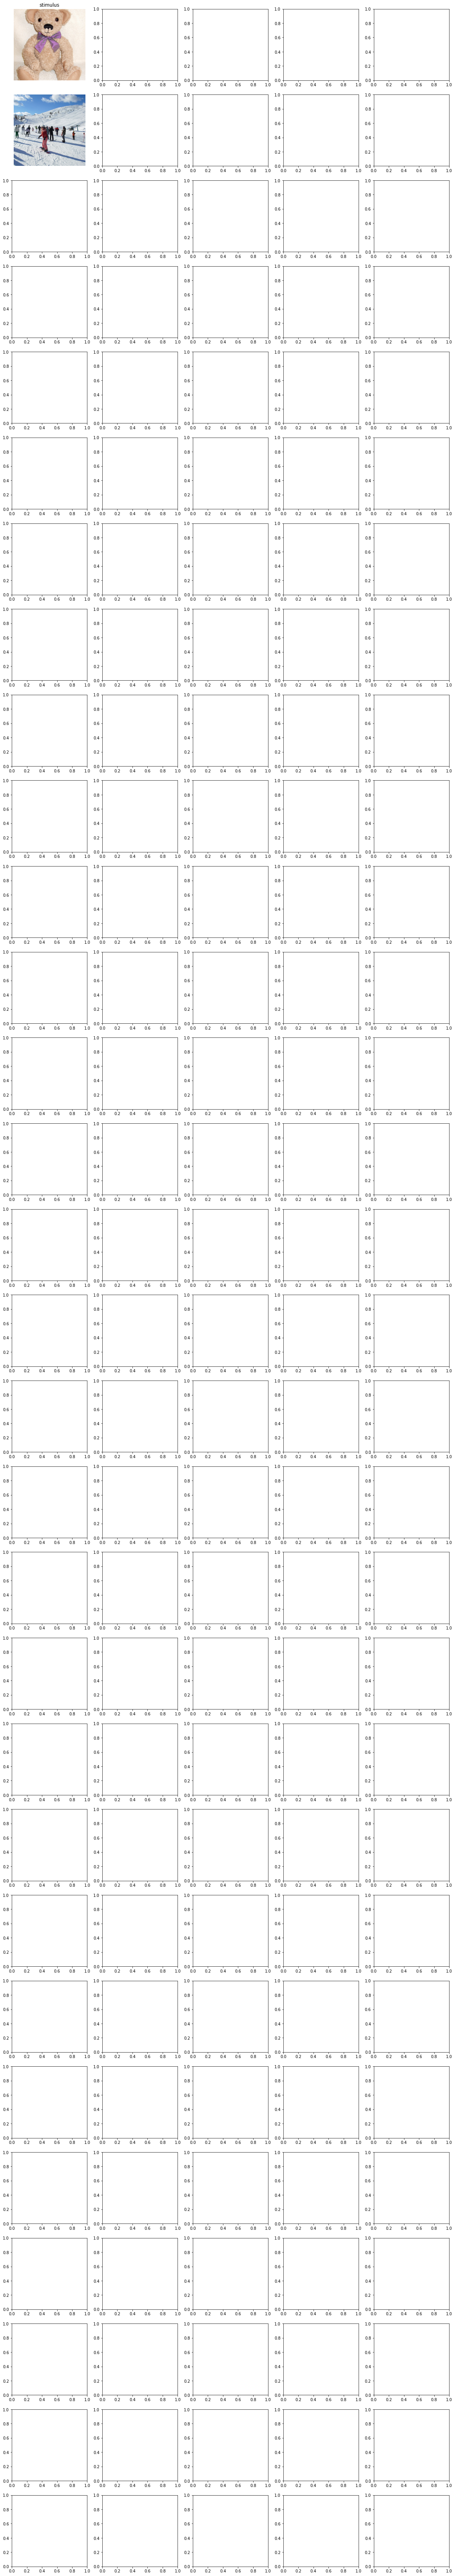

In [16]:
plot_images(generated, y,column_titles)

## Decode all test set for aligned subjects and save images to wandb

In [49]:
config={"target_sub":target_sub_idx,}
wandb.init(project="BrainDecodingNSD_MNI", config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante. Use `wandb login --relogin` to force relogin


In [1]:
method="randomhyper"
decode_all=False

In [ ]:
if decode_all:
    for fraction in [100,50,25,10]:
        subj_generated=[]
        print("fraction",fraction)
        to_pil=torchvision.transforms.ToPILImage()
        for source_idx in [1,2,5,7]:

            print("subject", source_idx)  
            generated=[] 

            stimuli=[]
            BS=4
            ## comparison



            dataset=get_dataset(source_idx,target_sub_idx,method=method,split="comparison",fraction=fraction)
            # other_dataset=NSDDataset(data,imgs_data,captions_test_data,transforms=tr)
            dataloader=DataLoader(dataset,batch_size=BS,shuffle=False)


            for x,y,c in dataloader:

                x_norm=torch.nan_to_num((x-mean)/std)
                image_generated,guess_img=brain_decoder.decode(x_norm)
                generated+=image_generated

                stimuli+=[to_pil(i) for i in y]




            dataset=get_dataset(source_idx,target_sub_idx,method=method,split="test",fraction=fraction)



            # other_dataset=NSDDataset(data,imgs_data,captions_test_data,transforms=tr)
            dataloader=DataLoader(dataset,batch_size=BS,shuffle=False)


            for x,y,c in dataloader:

                x_norm=torch.nan_to_num((x-mean)/std)
                image_generated,guess_img=brain_decoder.decode(x_norm)
                generated+=image_generated

                stimuli+=[to_pil(i) for i in y]


            subj_generated.append(generated)


        cols=["Stimuli","Subj01", "Subj02", "Subj05", "Subj07"]
        table = wandb.Table(columns=cols)

        for i in range(len(stimuli)):

            imgs=(stimuli[i], subj_generated[0][i],subj_generated[1][i],subj_generated[2][i],subj_generated[3][i])
            imgs=(wandb.Image(x) for x in imgs)
            table.add_data(*imgs)


        wandb.log({f"table_{method}_{fraction}":table})

        wandb.alert(
        title='Data loaded',
        text=f'Loaded table_{method}_{fraction}',
      )

fraction 100
subject 1
source_idx and target_idx are the same


100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 39.78it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 50.12it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 53.52it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 42.55it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 36.93it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 55.12it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 138.89it/s]


tensor(1.)
[INFO] Final reconstrution 1/2


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/2


  0%|          | 0/37 [00:00<?, ?it/s]

source_idx and target_idx are the same


100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 356.06it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 409.18it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 367.87it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 436.82it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 333.57it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 282.74it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 443.46it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 442.11it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 397.16it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 420.32it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 380.79it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 413.64it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 409.88it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 432.04it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 427.60it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 366.36it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 472.04it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 480.36it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 485.91it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 490.62it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 481.68it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 474.02it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 454.95it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 463.89it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 461.26it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 477.27it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 462.31it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 397.91it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 461.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 454.12it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 331.72it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 442.61it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 431.98it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 430.61it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 415.29it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 407.36it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 431.23it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 439.80it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 445.26it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 414.01it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 233.86it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 437.47it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 410.70it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 411.48it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 443.84it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 457.93it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 450.24it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 451.95it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:04<00:00, 17.66it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:08<00:00,  8.94it/s]


tensor(0.9176)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 44.41it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.72it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.21it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.21it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.48it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 42.03it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.18it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.59it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.19it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 39.57it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.18it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.88it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.93it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.77it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 21.52it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.03it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:00<00:00, 83.23it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 447.57it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 442.36it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 448.02it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 465.69it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 400.61it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 473.77it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 474.98it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 473.86it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 443.38it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 482.19it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 417.50it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 424.00it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 471.09it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 494.82it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 484.46it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 522.20it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 424.62it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 500.50it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 490.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 487.44it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 321.23it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 405.14it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 506.89it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 512.57it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 507.27it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 514.96it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 509.62it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 494.10it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 424.56it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 501.79it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 404.82it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 501.91it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 510.37it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 509.23it/s]


tensor(0.9412)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 514.35it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 106.06it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 45.78it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.59it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 48.81it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.33it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 47.79it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 46.12it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 53.79it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 54.07it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 50.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 39.51it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 43.68it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 39.38it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 45.55it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 39.93it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 45.44it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:00<00:00, 79.52it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 42.96it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 43.90it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.62it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 31.72it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 51.19it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 47.09it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 44.43it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 39.84it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 34.58it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 30.45it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.10it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.99it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 48.42it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.67it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 29.76it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 36.31it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 37.20it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 24.38it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 35.60it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 32.43it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 27.67it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 29.55it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 26.83it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:06<00:00, 12.61it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:05<00:00, 14.80it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:05<00:00, 13.27it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:04<00:00, 18.47it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:04<00:00, 17.14it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:06<00:00, 12.50it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 19.30it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 30.53it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 36.63it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 33.20it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 32.24it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 33.84it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 34.56it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 32.00it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 29.58it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 30.61it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 33.05it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 35.72it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 37.02it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 26.45it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 251.23it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 261.30it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 243.46it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 186.19it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 135.10it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 255.50it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 243.58it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 288.64it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 304.15it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 303.92it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 278.49it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 286.95it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 226.34it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 295.23it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 299.89it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 297.79it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 459.09it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 416.25it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 421.01it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 414.26it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 424.69it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 432.42it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 438.12it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 366.98it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 431.13it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 425.96it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 413.73it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 429.50it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 421.98it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 427.61it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 417.19it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 428.08it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 352.53it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 352.18it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 416.70it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 411.63it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 410.03it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 418.04it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 444.63it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 406.55it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 414.39it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 447.41it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 439.86it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 422.30it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 447.79it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 426.71it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 436.07it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 408.43it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 428.33it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 399.42it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 386.98it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 395.00it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 413.80it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 368.89it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 418.94it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 421.53it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 434.62it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 439.94it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 449.74it/s]


tensor(0.9333)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:04<00:00, 18.19it/s]


tensor(0.8314)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 383.74it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:10<00:00,  7.63it/s]


tensor(0.8902)
[INFO] Final reconstrution 1/2


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/2


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 414.78it/s]


tensor(0.8392)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 445.37it/s]


tensor(0.8980)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 476.82it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 463.73it/s]


tensor(0.8235)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 473.22it/s]


tensor(0.9765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 466.31it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 460.75it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 467.24it/s]


tensor(0.8510)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 319.95it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 470.23it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 476.73it/s]


tensor(0.9412)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 479.01it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 478.60it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 478.69it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 459.17it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 266.82it/s]


tensor(0.8784)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 331.08it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 464.16it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 444.90it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 453.58it/s]


tensor(0.9333)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 458.63it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 447.88it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 445.39it/s]


tensor(0.8824)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 418.09it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 439.09it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 444.40it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 438.27it/s]


tensor(0.9569)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 452.50it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 360.68it/s]


tensor(0.8784)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 301.03it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:05<00:00, 13.54it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:12<00:00,  6.38it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 35.24it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:04<00:00, 18.13it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 454.59it/s]


tensor(0.9569)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 34.68it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 34.84it/s]


tensor(0.9412)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 35.09it/s]


tensor(0.8627)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:06<00:00, 12.45it/s]


tensor(0.9373)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:04<00:00, 18.23it/s]


tensor(0.9569)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:06<00:00, 12.47it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:04<00:00, 16.37it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 467.80it/s]


tensor(0.9255)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 480.85it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 473.37it/s]


tensor(0.8706)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 472.32it/s]


tensor(0.9373)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 475.73it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 427.35it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 448.23it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 434.90it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 459.75it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 472.97it/s]


tensor(0.8784)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 460.73it/s]


tensor(0.8510)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 488.57it/s]


tensor(0.9059)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 440.52it/s]


tensor(0.9529)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 397.01it/s]


tensor(0.8431)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 395.96it/s]


tensor(0.8667)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 437.93it/s]


tensor(0.8667)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 456.92it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 448.68it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 426.73it/s]


tensor(0.9176)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 390.53it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 448.13it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 457.38it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 458.48it/s]


tensor(0.9529)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 343.17it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 458.09it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 460.56it/s]


tensor(0.9059)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 395.27it/s]


tensor(0.8863)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 467.21it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 465.50it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 453.72it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 421.90it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 418.67it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 443.46it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 441.80it/s]


tensor(0.8824)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 396.35it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 457.05it/s]


tensor(0.9765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 467.89it/s]


tensor(0.8706)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 456.92it/s]


tensor(0.8784)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 452.45it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 439.05it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 421.84it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 476.38it/s]


tensor(0.8863)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 463.26it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 424.64it/s]


tensor(0.8863)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 467.23it/s]


tensor(0.8941)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 434.75it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 413.84it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 466.70it/s]


tensor(0.9765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 454.19it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 351.60it/s]


tensor(0.8902)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 336.72it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 349.16it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 413.62it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 433.65it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 402.83it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 437.68it/s]


tensor(0.9255)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 453.37it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 454.24it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 444.40it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 445.69it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 323.48it/s]


tensor(0.9059)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 336.81it/s]


tensor(0.8941)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 400.27it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 432.63it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 389.68it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 298.87it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 270.60it/s]


tensor(0.9176)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 347.67it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 423.68it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 443.77it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 455.56it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 424.91it/s]


tensor(0.9333)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 450.51it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 433.74it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 450.41it/s]


tensor(0.8588)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 433.07it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 438.04it/s]


tensor(0.8353)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 399.67it/s]


tensor(0.8902)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 436.62it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 382.09it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 315.42it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 239.54it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 244.95it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 211.26it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 292.40it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 212.06it/s]


tensor(0.8431)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 255.88it/s]


tensor(0.8941)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 275.85it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 293.83it/s]


tensor(0.8118)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 290.88it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 292.12it/s]


tensor(0.9412)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 288.10it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 258.54it/s]


tensor(0.8549)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 258.27it/s]


tensor(0.9176)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 270.33it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 315.63it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 316.89it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 317.33it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 315.58it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 315.05it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 312.66it/s]


tensor(0.8980)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 314.57it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

subject 5


100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 321.19it/s]


tensor(0.8980)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 314.46it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 322.42it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 307.63it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 303.73it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 310.46it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 317.37it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 110.84it/s]


tensor(0.8078)
[INFO] Final reconstrution 1/2


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/2


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 280.36it/s]


tensor(0.8314)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 316.66it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 308.56it/s]


tensor(0.8902)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 296.36it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 291.77it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 308.73it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 312.73it/s]


tensor(0.9059)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 303.60it/s]


tensor(0.9176)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 312.05it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 314.22it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 307.76it/s]


tensor(0.8510)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 317.48it/s]


tensor(0.8941)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 307.86it/s]


tensor(0.7843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 307.78it/s]


tensor(0.9333)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 25.09it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 43.11it/s]


tensor(0.9333)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:05<00:00, 15.18it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 339.19it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 343.96it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:06<00:00, 11.56it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 22.55it/s]


tensor(0.8392)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:05<00:00, 15.40it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 43.55it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 44.08it/s]


tensor(0.8510)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 43.14it/s]


tensor(0.9176)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 43.22it/s]


tensor(0.8314)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 43.63it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 44.59it/s]


tensor(0.8510)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 42.29it/s]


tensor(0.8471)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:05<00:00, 14.11it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 378.66it/s]


tensor(0.8353)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 357.75it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 361.52it/s]


tensor(0.8078)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 359.56it/s]


tensor(0.9333)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 364.87it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 359.47it/s]


tensor(0.8039)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 350.10it/s]


tensor(0.8275)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 361.28it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 351.39it/s]


tensor(0.9137)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 361.57it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 359.51it/s]


tensor(0.8784)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 367.53it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 217.16it/s]


tensor(0.9373)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 358.45it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 357.74it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 364.49it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 308.16it/s]


tensor(0.7882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 357.81it/s]


tensor(0.8392)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 348.12it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 363.23it/s]


tensor(0.9255)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 338.27it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 372.48it/s]


tensor(0.8667)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 353.50it/s]


tensor(0.8980)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 358.16it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 365.36it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 366.34it/s]


tensor(0.8863)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 342.33it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 326.05it/s]


tensor(0.8941)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 360.80it/s]


tensor(0.8902)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 319.05it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 369.73it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 361.22it/s]


tensor(0.8000)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 359.82it/s]


tensor(0.8471)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 363.11it/s]


tensor(0.8431)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 361.34it/s]


tensor(0.8980)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 290.33it/s]


tensor(0.8667)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 351.68it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 353.94it/s]


tensor(0.8275)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 314.47it/s]


tensor(0.8784)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 351.62it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 374.89it/s]


tensor(0.9137)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 369.65it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 368.24it/s]


tensor(0.9137)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 370.32it/s]


tensor(0.9569)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 374.24it/s]


tensor(0.8588)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 366.79it/s]


tensor(0.8510)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 241.83it/s]


tensor(0.9529)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 347.24it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 304.26it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 351.77it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 291.67it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 304.75it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 298.21it/s]


tensor(0.8863)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 308.74it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 229.25it/s]


tensor(0.8784)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 311.50it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 270.73it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 305.25it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 307.64it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 259.75it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 308.81it/s]


tensor(0.9529)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 305.20it/s]


tensor(0.9255)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 298.58it/s]


tensor(0.9529)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 284.76it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 302.14it/s]


tensor(0.8588)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 278.75it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 293.58it/s]


tensor(0.9529)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 308.93it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 325.91it/s]


tensor(0.8627)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 311.37it/s]


tensor(0.8784)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 268.68it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 289.79it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 315.76it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 365.24it/s]


tensor(0.8941)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 358.75it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 362.35it/s]


tensor(0.9412)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 350.45it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 346.71it/s]


tensor(0.8392)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 322.60it/s]


tensor(0.9765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 399.81it/s]


tensor(0.9255)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 412.67it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 390.94it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 481.72it/s]


tensor(0.8706)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 489.18it/s]


tensor(0.8980)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 505.09it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 485.47it/s]


tensor(0.8667)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 479.34it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 477.49it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 488.21it/s]


tensor(0.8706)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 426.32it/s]


tensor(0.9412)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 469.24it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 479.48it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 448.20it/s]


tensor(0.9569)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 426.34it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 482.90it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 513.98it/s]


tensor(0.8196)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 260.91it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 488.84it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 484.97it/s]


tensor(0.8353)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 444.91it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 485.85it/s]


tensor(0.9765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 424.08it/s]


tensor(0.8667)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 491.01it/s]


tensor(0.8314)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 494.33it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 483.23it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 486.32it/s]


tensor(0.8824)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 469.86it/s]


tensor(0.8471)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 415.27it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 484.99it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 462.36it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 453.99it/s]


tensor(0.8824)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 498.63it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 440.75it/s]


tensor(0.9333)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 468.90it/s]


tensor(0.9765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 463.83it/s]


tensor(0.8235)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 481.99it/s]


tensor(0.8431)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 464.31it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 461.12it/s]


tensor(0.8471)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 449.20it/s]


tensor(0.8549)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 462.92it/s]


tensor(0.9765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 467.91it/s]


tensor(0.8824)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 270.66it/s]


tensor(0.8235)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 467.09it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 481.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 482.35it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 489.11it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 311.22it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 51.66it/s]


tensor(0.9529)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 52.41it/s]


tensor(0.7922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 51.99it/s]


tensor(0.9333)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 52.60it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 52.78it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 26.81it/s]


tensor(0.8667)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 50.65it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:05<00:00, 13.42it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 49.26it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 49.97it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 50.05it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 50.31it/s]


tensor(0.8314)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 49.00it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 48.56it/s]


tensor(0.9176)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 24.13it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 26.61it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:05<00:00, 14.10it/s]


tensor(0.8549)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 54.13it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 292.06it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 28.37it/s]


tensor(0.9373)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 70.24it/s]


tensor(0.9529)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 42.32it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 48.08it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 45.93it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 49.21it/s]


tensor(0.8706)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 74.04it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 36.55it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 51.34it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 42.64it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 103.30it/s]


tensor(0.8980)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 38.13it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 67.52it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 72.78it/s]


tensor(0.9373)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 39.15it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 60.78it/s]


tensor(0.9059)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.56it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 36.04it/s]


tensor(0.8941)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 42.42it/s]


tensor(0.9255)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 39.36it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 68.83it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.31it/s]


tensor(0.9176)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 46.32it/s]


tensor(0.8863)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 57.03it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 54.59it/s]


tensor(0.8118)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 37.93it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.13it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 37.53it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 31.58it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 23.15it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 24.52it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 33.64it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 33.63it/s]


tensor(0.9569)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.20it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 28.59it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 35.63it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 30.62it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 29.61it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 25.19it/s]


tensor(0.9569)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 26.44it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 35.21it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 33.06it/s]


tensor(0.9137)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 34.52it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.00it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 64.20it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 38.62it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 38.70it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 26.18it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 38.01it/s]


tensor(0.9137)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 24.55it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 27.91it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 36.19it/s]


tensor(0.8431)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 38.31it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 38.83it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 30.64it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.20it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 37.89it/s]


tensor(0.9333)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.49it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 23.99it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 28.49it/s]


tensor(0.9569)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 24.26it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:04<00:00, 16.35it/s]


tensor(0.9412)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

subject 7


100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 35.24it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 20.76it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 70.50it/s]


tensor(0.9412)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 67.86it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 67.21it/s]


tensor(0.7765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 63.81it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 36.50it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 25.60it/s]


tensor(1.)
[INFO] Final reconstrution 1/2


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/2


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 417.29it/s]


tensor(0.8353)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 65.79it/s]


tensor(0.8314)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 65.57it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 66.86it/s]


tensor(0.8588)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 64.98it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 231.86it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 265.48it/s]


tensor(0.8706)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 342.60it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 376.36it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 369.89it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 340.03it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 344.06it/s]


tensor(0.8078)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 307.34it/s]


tensor(0.9569)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 236.04it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 232.26it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 231.56it/s]


tensor(0.8667)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 217.64it/s]


tensor(0.9529)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 228.95it/s]


tensor(0.9569)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 215.20it/s]


tensor(0.8706)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 206.15it/s]


tensor(0.9176)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 208.06it/s]


tensor(0.8667)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 215.28it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 218.10it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 233.90it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 228.42it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 236.17it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 289.72it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 255.90it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 286.09it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 306.18it/s]


tensor(0.8784)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 258.28it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 301.97it/s]


tensor(0.8824)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 174.28it/s]


tensor(0.9373)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 259.00it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 276.08it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 281.24it/s]


tensor(0.9765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 279.50it/s]


tensor(0.8706)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 280.45it/s]


tensor(0.8667)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 409.43it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 379.81it/s]


tensor(0.8941)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 366.03it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 376.82it/s]


tensor(0.8235)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 328.82it/s]


tensor(0.8353)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 283.32it/s]


tensor(0.8902)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 395.26it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 416.87it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 369.79it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 462.00it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 441.76it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 465.15it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 468.28it/s]


tensor(0.8275)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 372.96it/s]


tensor(0.9255)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 424.94it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 416.89it/s]


tensor(0.8980)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 411.52it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 417.76it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 415.67it/s]


tensor(0.8706)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 417.46it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 414.63it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 414.14it/s]


tensor(0.8627)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 414.36it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 418.39it/s]


tensor(0.8510)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 413.39it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 398.40it/s]


tensor(0.8353)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 433.48it/s]


tensor(0.7608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 405.55it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 459.97it/s]


tensor(0.8471)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 454.70it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 481.89it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 454.54it/s]


tensor(0.8902)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 454.63it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 444.12it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 483.03it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 476.43it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 489.29it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 474.79it/s]


tensor(0.7882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 477.48it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 476.08it/s]


tensor(0.8196)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 485.65it/s]


tensor(0.9412)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 471.25it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 276.70it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 482.11it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 491.90it/s]


tensor(0.9373)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 501.12it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 492.18it/s]


tensor(0.8196)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 499.65it/s]


tensor(0.8588)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 500.86it/s]


tensor(0.8235)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 473.58it/s]


tensor(0.8706)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 486.77it/s]


tensor(0.9255)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 455.40it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 49.19it/s]


tensor(0.8941)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 49.30it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 50.67it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 50.65it/s]


tensor(0.9098)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 48.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 49.36it/s]


tensor(0.9608)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 25.60it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 49.36it/s]


tensor(0.9412)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 48.59it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 48.42it/s]


tensor(0.9333)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 24.92it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 452.96it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 48.56it/s]


tensor(0.8784)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 49.89it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 49.83it/s]


tensor(0.9255)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 50.14it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 48.69it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:03<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 51.87it/s]


tensor(0.8510)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 49.30it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 107.22it/s]


tensor(0.9490)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 515.79it/s]


tensor(0.9765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 448.20it/s]


tensor(0.7804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 441.33it/s]


tensor(0.9137)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 489.40it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 218.64it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 244.10it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 282.01it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 483.88it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 486.85it/s]


tensor(0.9059)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 475.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 496.00it/s]


tensor(0.9176)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 357.88it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 428.37it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 490.64it/s]


tensor(0.9333)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 446.06it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 451.94it/s]


tensor(0.9216)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 500.71it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 453.64it/s]


tensor(0.9765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 505.55it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 439.05it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 401.70it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 444.64it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 447.16it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 433.51it/s]


tensor(0.8863)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 442.40it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 428.59it/s]


tensor(0.9529)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 444.62it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 439.14it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 407.60it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 388.90it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 403.78it/s]


tensor(0.8941)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 348.78it/s]


tensor(0.8392)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 361.24it/s]


tensor(0.8431)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 370.26it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 411.59it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 422.75it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 353.77it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 152.51it/s]


tensor(1.)
[INFO] Final reconstrution 1/2


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/2


  0%|          | 0/37 [00:00<?, ?it/s]

source_idx and target_idx are the same


100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 441.85it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 141.19it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 25.89it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 467.22it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 455.50it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 431.53it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 396.34it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 268.31it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 464.03it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 461.25it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 451.99it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

 86%|██████████████████████████████████▏     | 220/257 [00:02<00:00, 117.96it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 449.14it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 374.32it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 441.33it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 403.85it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 420.97it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 387.80it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 381.75it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 394.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 397.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 409.08it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 388.06it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 404.11it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 352.21it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 418.69it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 406.83it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 454.46it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 485.96it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 508.13it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 534.39it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 545.09it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 478.23it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 500.28it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 524.70it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:06<00:00, 12.22it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:06<00:00, 11.79it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 456.71it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 445.47it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 434.52it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 436.69it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 365.50it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 463.29it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 426.49it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 424.86it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 435.82it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 442.49it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 438.52it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 454.00it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 459.15it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 368.39it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 445.55it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 422.23it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 429.69it/s]


tensor(0.9020)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 430.39it/s]


tensor(0.8118)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 405.86it/s]


tensor(0.9451)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 373.13it/s]


tensor(0.9294)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 445.49it/s]


tensor(0.9059)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 477.31it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 475.67it/s]


tensor(0.8824)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 480.91it/s]


tensor(0.9059)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 484.76it/s]


tensor(0.9373)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 462.04it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 448.09it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 460.80it/s]


tensor(0.9843)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 479.07it/s]


tensor(0.9686)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 485.83it/s]


tensor(0.7961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 485.98it/s]


tensor(0.8353)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 471.58it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 494.94it/s]


tensor(0.9961)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 478.39it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 39.85it/s]


tensor(0.9804)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.33it/s]


tensor(0.8667)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.74it/s]


tensor(0.9765)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 40.81it/s]


tensor(0.9725)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 488.77it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 376.28it/s]


tensor(0.8745)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

KeyboardInterrupt: 

wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run eager-river-4 at: https://wandb.ai/matteoferrante/BrainDecodingNSD_MNI/runs/59s9cbrb
wandb: Synced 6 W&B file(s), 13 media file(s), 49193 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230618_104243-59s9cbrb/logs


## Anat

In [75]:
if decode_all:
    method="anat"
    subj_generated=[]
    to_pil=torchvision.transforms.ToPILImage()
    for source_idx in [1,2,5,7]:

        print("subject", source_idx)  
        generated=[] 

        stimuli=[]
        BS=4
        ## comparison



        dataset=get_dataset(source_idx,target_sub_idx,method=method,split="comparison",fraction=fraction)
        # other_dataset=NSDDataset(data,imgs_data,captions_test_data,transforms=tr)
        dataloader=DataLoader(dataset,batch_size=BS,shuffle=False)


        for x,y,c in dataloader:

            x_norm=torch.nan_to_num((x-mean)/std)
            image_generated,guess_img=brain_decoder.decode(x_norm)
            generated+=image_generated

            stimuli+=[to_pil(i) for i in y]




        dataset=get_dataset(source_idx,target_sub_idx,method=method,split="test",fraction=fraction)



        # other_dataset=NSDDataset(data,imgs_data,captions_test_data,transforms=tr)
        dataloader=DataLoader(dataset,batch_size=BS,shuffle=False)


        for x,y,c in dataloader:

            x_norm=torch.nan_to_num((x-mean)/std)
            image_generated,guess_img=brain_decoder.decode(x_norm)
            generated+=image_generated

            stimuli+=[to_pil(i) for i in y]


        subj_generated.append(generated)


    cols=["Stimuli","Subj01", "Subj02", "Subj05", "Subj07"]
    table = wandb.Table(columns=cols)

    for i in range(len(stimuli)):

        imgs=(stimuli[i], subj_generated[0][i],subj_generated[1][i],subj_generated[2][i],subj_generated[3][i])
        imgs=(wandb.Image(x) for x in imgs)
        table.add_data(*imgs)


    wandb.log({f"table_{method}_{fraction}":table})

    wandb.alert(
    title='Data loaded',
    text=f'Loaded table_{method}_{fraction}',
    )

subject 1
source_idx and target_idx are the same


100%|███████████████████████████████████████████| 77/77 [00:39<00:00,  1.93it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 397.88it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 406.27it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 398.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 348.98it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 404.44it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 406.38it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 135.87it/s]


tensor(1.)
[INFO] Final reconstrution 1/2


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/2


  0%|          | 0/37 [00:00<?, ?it/s]

source_idx and target_idx are the same


100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 404.69it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 399.03it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 372.71it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 406.71it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 269.79it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 336.81it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 357.56it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 409.44it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 410.64it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 384.80it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 364.40it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 333.98it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 373.10it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 375.14it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 370.00it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 377.21it/s]


tensor(0.9882)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 377.43it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 376.00it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 469.33it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 453.31it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 479.75it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 429.34it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 452.67it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 36.03it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 421.08it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 417.05it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 420.38it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 398.86it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 396.36it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 435.96it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 432.38it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 425.31it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 426.85it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 435.91it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 418.14it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 419.91it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 434.47it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 389.88it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 309.49it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 232.99it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 269.31it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 424.85it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 469.45it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 461.83it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 463.00it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 430.28it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 431.40it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 430.58it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 42.40it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 43.29it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 41.63it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 452.19it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 452.92it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 450.22it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 462.04it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 456.28it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 459.77it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 439.10it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 403.55it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 451.69it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 252.29it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 411.42it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 398.83it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 446.42it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 433.57it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 414.32it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 432.79it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 436.75it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 440.02it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 418.12it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 441.49it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 442.29it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 377.46it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 455.17it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 460.89it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 346.43it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 444.52it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 432.28it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 427.47it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 475.23it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 22.63it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 42.57it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 369.64it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 451.37it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 450.17it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 448.85it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 451.53it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 367.73it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 455.51it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 419.81it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 440.03it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 456.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 416.18it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 388.83it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 389.03it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 388.64it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 406.67it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 337.48it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 383.81it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 385.71it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 387.96it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 436.46it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 443.87it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 429.29it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 466.41it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 432.88it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 449.49it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 469.95it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 422.80it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 458.91it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|                                                   | 0/257 [00:00<?, ?it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 457.94it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 46.88it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 47.01it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 47.51it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 452.98it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 47.99it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 188.59it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 398.83it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 449.75it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 354.80it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 449.45it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 452.42it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 415.36it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 423.03it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 360.43it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 436.98it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 343.79it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 385.81it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 434.36it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 444.57it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 446.12it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 406.53it/s]


tensor(0.9647)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 397.23it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 409.18it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 429.38it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 418.87it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 363.41it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 419.38it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 425.41it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 431.15it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 425.99it/s]


tensor(0.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 48.20it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 218.06it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 23.74it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 392.08it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 470.07it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 23.19it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 481.45it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 471.60it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 479.30it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 390.08it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 483.69it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 466.07it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 436.66it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 417.27it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 421.03it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 376.58it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 410.11it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|                                                   | 0/257 [00:00<?, ?it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 443.23it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 376.45it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 441.49it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 426.44it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 439.71it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 423.38it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 439.48it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 466.06it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 477.82it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 462.81it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 457.84it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 473.11it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 43.92it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 23.23it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 44.53it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 448.65it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 401.80it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 463.02it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 457.64it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 322.88it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 467.85it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 450.92it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 464.63it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 432.80it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 463.58it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 458.18it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 401.50it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 420.82it/s]


tensor(1.)
[INFO] Final reconstrution 1/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 2/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 3/4


  0%|          | 0/37 [00:00<?, ?it/s]

[INFO] Final reconstrution 4/4


  0%|          | 0/37 [00:00<?, ?it/s]

In [67]:
# cols=["Stimuli","Subj01", "Subj02", "Subj05", "Subj07"]
# table = wandb.Table(columns=cols)

# for i in range(len(stimuli)):
    
#     imgs=(stimuli[i], subj_generated[0][i],subj_generated[1][i],subj_generated[2][i],subj_generated[3][i])
#     imgs=(wandb.Image(x) for x in imgs)
#     table.add_data(*imgs)
    
    
# wandb.log({f"table_{method}_{fraction}_check2":table})

## Sample 500 images from train set for aligned subjects